In [ ]:
%matplotlib inline

code for mounting the google drive if dataset from google drive is used.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Code for archiving the dataset.

In [ ]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/drive/MyDrive/arc.zip').extractall('/content/sample_data')

     |████████████████████████████████| 81kB 5.5MB/s 


In [ ]:
!pip3 install --user Flask

In [ ]:
#!pip3 install --user tensorflow
#!pip3 install --user keras
#!pip3 install --user  pandas

Importations

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

Loading the dataset

In [ ]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = '/content/sample_data/PlantVillage'
train_dir = os.path.join(data_dir)

Preprocessing of data

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
20634,Tomato_healthy/989dc406-c1db-4a9c-9cda-ae66f12...,14,Tomato_healthy
20635,Tomato_healthy/2d9352d7-2509-40a1-be35-0140444...,14,Tomato_healthy
20636,Tomato_healthy/49d1f23f-f284-4397-a0a3-295f4ea...,14,Tomato_healthy
20637,Tomato_healthy/db467743-857b-42b3-ab2a-a80e904...,14,Tomato_healthy
20638,Tomato_healthy/efe6c986-b85c-40f1-8cb5-345acbb...,14,Tomato_healthy


Taking seed in order to get consistent results.

In [ ]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato_healthy/058ade43-2361-4039-bbe5-0ac6618...,14,Tomato_healthy
1,Potato___Early_blight/e3007682-ad4b-4a62-b64d-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot/e65190f0-97e9-44a6-b...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/717a4bbc-52b1-42c1-a718-ca94744...,14,Tomato_healthy
4,Tomato_Leaf_Mold/77cd3874-ca19-4bfc-a112-696b2...,8,Tomato_Leaf_Mold


Plotting a histogram between disease ID and its frequency.

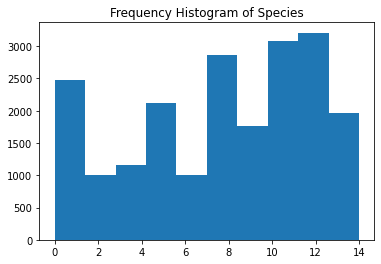

<Figure size 864x864 with 0 Axes>

In [ ]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

Displaying images for different species

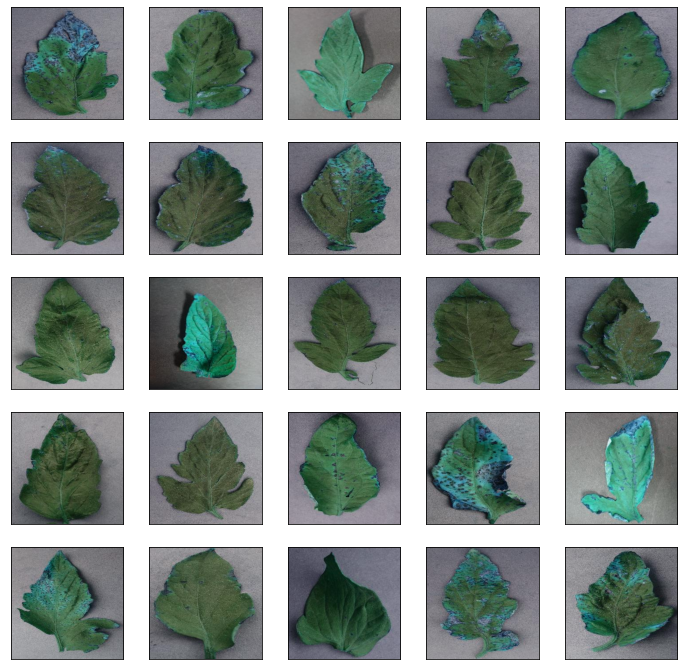

In [ ]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Bacterial_spot', 5, 5)

Color and size preprocessing of dataset

In [ ]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

Data Normalization

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

20639it [00:44, 463.98it/s]


Train Shape: (20639, 64, 64, 3)


Data Encoding

In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

Splitting the dataset in to testing and training sub-datasets.

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

Displaying the images with their labels in training dataset.

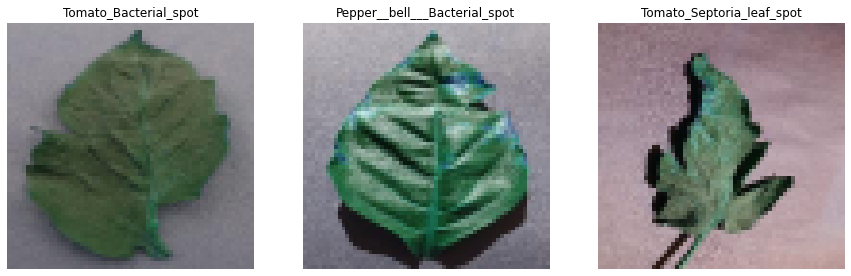

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

Parametrization

In [ ]:
EPOCHS = 50
SIZE=64
N_ch=3

Building DenseNet 121 Model

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

Fitting the model onto the dataset. ( To increase the accurary increase the number of epocs upto 50)

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))
model.save("dhaan.h5")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2624

Creating the tar file of the model

In [ ]:
!tar -zcvf model.tgz model.h5

model.h5


Checking whether all the required files are there.

In [ ]:
!ls -l

total 249156
-rw-r--r-- 1 root root 88636288 May 23 14:27 dhaan.h5
drwx------ 5 root root     4096 May 23 13:12 drive
-rw-r--r-- 1 root root 88636288 May 23 14:27 model.h5
-rw-r--r-- 1 root root 77850704 May 23 14:27 model.tgz
drwxr-xr-x 1 root root     4096 May 23 13:13 sample_data


Loading the model.

In [ ]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
model = load_model('//content/sample_data/arc/dhaani.h5')


[1.0177568e-04 9.8862785e-01 3.2037254e-03 1.0097311e-05 2.0022490e-03
 1.5239542e-06 1.0597994e-04 7.7035866e-04 4.1435112e-04 4.0516513e-03
 7.5372277e-06 3.2359036e-05 1.9299607e-07 3.7734651e-05 6.3248974e-04]


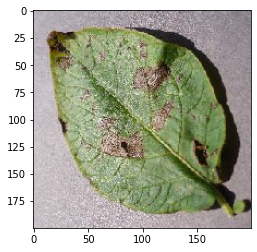

Prediction: Pepper__bell___healthy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/sample_data/arc/0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/sample_data/arc/0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG', grayscale=False, target_size=(200, 200))
disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])



#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])
Disease_name = disease_class[ind]

In [ ]:
if(Disease_name == "Tomato__Tomato_mosaic_virus"):
    print("""Cultural control :\n\nUse certified disease-free seed or treat your own seed.\n
Soak seeds in a 10% solution of trisodium phosphate (Na3PO4) for at least 15 minutes.\n
Or heat dry seeds to 158 °F and hold them at that temperature for two to four days.\n
Purchase transplants only from reputable sources. Ask about the sanitation procedures they use to prevent disease.\n
Inspect transplants prior to purchase. Choose only transplants showing no clear symptoms.\n
Avoid planting in fields where tomato root debris is present, as the virus can survive long-term in roots.\n
Wash hands with soap and water before and during the handling of plants to reduce potential spread between plants.\n
Disinfect tools regularly — ideally between each plant, as plants can be infected before showing obvious symptoms.\n
Soaking tools for 1 minute in a 1:9 dilution of germicidal bleach is highly effective.\n
Or a 1-minute soak in a 20% weight/volume solution of nonfat dry milk and water is also very effective.\n
When pruning plants, have two pruners and alternate between them to allow proper soaking time between plants.\n
Avoid using tobacco products around tomato plants, and wash hands after using tobacco products and before working with the plants.\n
Tobacco in cigarettes and other tobacco products may be infected with either ToMV or TMV, both of which could spread to the tomato plants.\n
Scout plants regularly. If plants displaying symptoms of ToMV or TMV are found, remove the entire plant (including roots), bag the plant, and send it to the University of Minnesota Plant Diagnostic Clinic for diagnosis.\n
If ToMV or TMV is confirmed, employ stringent sanitation procedures to reduce spread to other plants, fields, tunnels and greenhouses.\n
Completely pull up and burn infected plants. Do not compost infected plant material.\n
After working with diseased plants, thoroughly disinfect all tools and hands as outlined above.\n
For added security against spread, keep separate tools for working in the diseased area and avoid working with healthy plants after working in an area with diseased plants.\n
At the end of the season, burn all plants from diseased areas, even healthy-appearing ones, or bury them away from vegetable production areas.\n
Disinfect stakes, ties, wires or any other equipment between growing seasons using the methods noted above.\n
Chemical control\n
There are currently no chemical options that are effective against either virus.\n""")
print("Control strategy would be provided for all the diseases in future")

Control strategy would be provided for all the diseases in future
